In [1]:
import numpy as np
import pandas as pd

# Read Data

In [2]:
def create_df():
    data = {'Source':[], 'Sink':[]}
    with open("train.txt", "r") as f:
        for line in f:
            data['Source'] += [line[0]]*(len(line)-1)
            data['Sink'] += line[1:]
    pd_data = pd.DataFrame(data=data)
    pd_data[['Source', 'Sink']] = pd_data[['Source', 'Sink']].apply(pd.to_numeric)
    return pd_data

In [3]:
def read_test():
    return pd.read_csv("test-public.txt", delimiter="\t", index_col=0)

In [4]:
# 10 graph data is sampled from the train data to visualise the network
graph_data = create_df()

# train set data
data = create_df()

# test set data
test = read_test()

MemoryError: occurred at index Source

In [165]:
test.to_csv('test.csv')

# Data Filtering

Data assumption: 

No isolated node in the network, i.e.every ID is related to at least one other ID.

#### REMOVE DUPLICATED DATA

In [5]:
# Original data size:
data.shape

(11714162, 2)

In [6]:
# Remove duplicated data
data = data.drop_duplicates()
data.shape

(11690629, 2)

In [7]:
print('The number of duplicated data entries:', 11714162 - 11690629)

The number of duplicated data entries: 23533


# Data Visualisation

In [8]:
import random
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
sample = data.sample(n = 6000, random_state = 1031)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


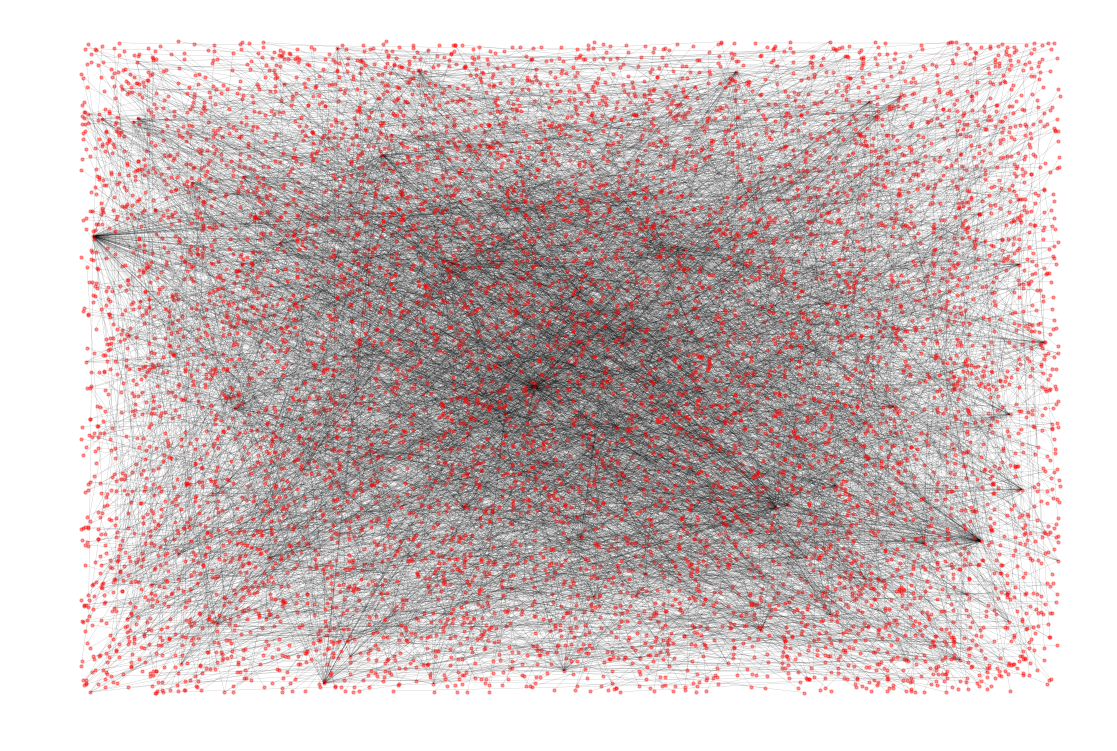

In [10]:
G = nx.from_pandas_edgelist(sample, 'Source', 'Sink', create_using = nx.Graph())

# Plot graph
plt.figure(figsize=(15,10))
pos = nx.random_layout(G, seed = 31)
nx.draw(G, with_labels = False,  pos = pos, node_size = 10, alpha = 0.4, width = 0.2)
plt.show()

# Some data points have distinctively dense out nodes 

# Data Analysis

#### NUMBER OF DATA IN TEST BUT NOT IN TRAIN
Handle unseen ID: Treat as majority node behaviour

In [11]:
# number of data in test but not in train
non_exist = 0
test_people = set(test['Source'])
train_people = set(data['Source'])
train_people.update(set(data['Sink']))
for i in test_people:
    if i not in train_people:
        non_exist += 1
print(non_exist)

23


#### PROPORTION OF PEOPLE FOLLOWING AND BEING FOLLOWED

In [12]:
# Total number of ID:
total = set(data['Source'])
total.update(set(data['Sink']))
total = len(total)
print('The total number of IDs', total)

source = (data['Source'].value_counts())
sink = (data['Sink'].value_counts())
print('Source number', len(source.keys()))
print('Sink number', len(sink.keys()))
print('The proportion of people being followed by ast least one person:', (len(sink.keys()))/total)
print('The proportion of people following at least one person:', len(source.keys())/total)

The total number of IDs 2858508
Source number 9792
Sink number 2858217
The proportion of people being followed by ast least one person: 0.9998981986406895
The proportion of people following at least one person: 0.0034255632658715665


In [18]:
source_df = pd.DataFrame(source)
sink_df = pd.DataFrame(sink)
source_df.describe()

,Source
count,9792.000000
mean,1193.895935
std,7526.216247
min,1.000000
25%,58.000000
50%,160.000000
75%,474.000000
max,411419.000000


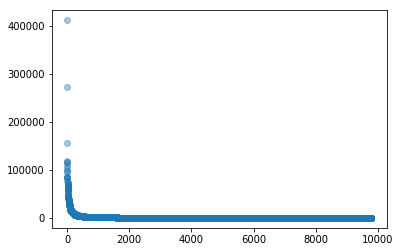

In [52]:
plt.scatter(range(len(source_df)), source_df['Source'], alpha = 0.4)

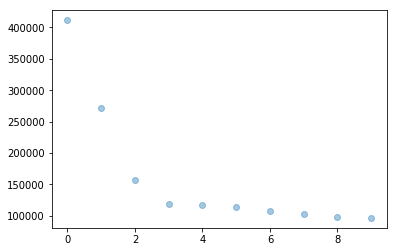

In [76]:
# Locate counts more than 100000 and check if they are dummy accounts
extremes = source_df.loc[(source_df['Source']>90000)]
plt.scatter(range(len(extremes)), extremes['Source'], alpha = 0.4)

In [82]:
extreme_id = list(extremes.index)
print(extreme_id)
#sink_df.loc[3280389]['Sink']

[3280389, 2827436, 427805, 805360, 4011264, 1927211, 3765475, 2961801, 2260014, 4191410]


549

In [92]:
# To check if these accounts are dummies, we calculate the proportion of the followees and followers
# If the proportion is less than 0.05, we decide they are dummies and may deviate our model, so we remove them
remove_ex = []
for ID in extreme_id:
    follower = sink_df.loc[ID]['Sink']
    followee = source_df.loc[ID]['Source']
    #print(follower/followee)
    if follower/followee < 0.005:
        remove_ex.append(ID)
print(remove_ex)

[3280389, 2827436, 427805, 3765475]


#### STRATEFY SAMPLING

In [102]:
layer = [90000, 40000, 20000, 10000, 2000, 500, 0][::-1]
layer

[0, 500, 2000, 10000, 20000, 40000, 90000]

In [150]:
def StratifySampling(layer, df, colname):
    sampled_id = []
    for l in range(1, len(layer)):
        cur_df = df.loc[(df[colname]<layer[l]) & (df[colname]>= layer[l-1])]
        sample = cur_df.sample(frac = 0.4, random_state = 1031)
        sampled_id += (list(sample.index))
    return sampled_id
sampled_source = StratifySampling(layer, source_df, 'Source')

In [127]:
# Now we sample from the Sink side
sink_df.describe()

,Sink
count,2.858217e+06
mean,4.090182e+00
std,1.428791e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.393000e+03


In [135]:
abnorm = sink_df.loc[(sink_df['Sink']>2000)]
source_df.loc[abnorm.index[1]]

print('This is does not follow any one:', abnorm.index[0])

This is does not follow any one: 3361377


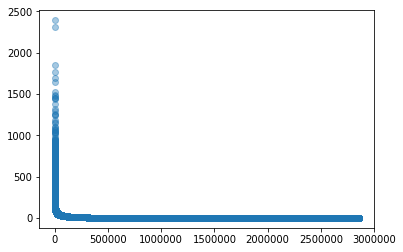

In [126]:
plt.scatter(range(len(sink_df)), sink_df['Sink'], alpha = 0.4)

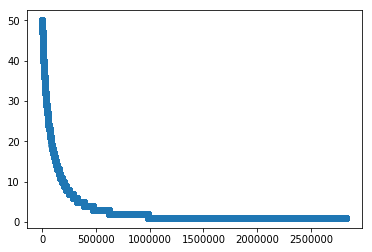

In [137]:
cur_df = sink_df.loc[(sink_df['Sink']<=50)]
plt.scatter(range(len(cur_df)), cur_df['Sink'], alpha = 0.4)

In [151]:
layer_sink = [0, 50, 500, 1000, 2500]
def StratifySampling(layer, df, colname):
    sampled_id = []
    for l in range(1, len(layer)):
        cur_df = df.loc[(df[colname]<layer[l]) & (df[colname]>= layer[l-1])]
        sample = cur_df.sample(frac = 0.04, random_state = 1986)
        sampled_id += (list(sample.index))
    return sampled_id
sampled_sink = StratifySampling(layer_sink, sink_df, 'Sink')

In [152]:
sampled_ids = sampled_source+sampled_sink
len((sampled_ids))

118242

In [153]:
data.head()

,Source,Sink
0,2129843,65840
1,2129843,3414168
2,2129843,4523797
3,2129843,2851163
4,2129843,4321895


In [161]:
sampled_df = data.loc[(data['Source'].isin(sampled_source)) & (data['Sink'].isin(sampled_sink)) & (~data['Source'].isin(remove_ex))]
sampled_df.head()

,Source,Sink
4843,2673351,2559016
4873,2673351,4232730
4876,2673351,565730
4879,2673351,3872816
4919,2673351,3607942


In [162]:
# resulting sampled data
sampled_df.shape

(163673, 2)

In [163]:
sampled_df.to_csv('processed_train.csv', index = False)

# Feature Engineering

In [14]:
#data = pd.read_csv('processed_train.csv')
#data.head()